In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import zscore
from sklearn import preprocessing


In [22]:
def load_dataset_from_github(api_directory_url):
    """
    Given a GitHub API URL pointing to a repository directory, fetches all CSV files
    in that directory and returns a dictionary mapping filenames to pandas DataFrames.

    Parameters:
    -----------
    api_directory_url : str
        GitHub API URL for a repository directory, e.g.
        "https://api.github.com/repos/username/repo/contents/path/to/dir"

    Returns:
    --------
    dict[str, pandas.DataFrame]
        A dictionary where each key is a CSV filename (e.g., "data.csv")
        and each value is the corresponding DataFrame obtained from reading
        the file's raw URL.
    array of dataframes
    """
    response = requests.get(api_directory_url)
    response.raise_for_status()  # Raise an error if request failed
    files = response.json()

    dataframes = {}
    for file in files:
        name = file.get("name", "")
        if name.endswith(".csv"):
            raw_url = file.get("download_url")
            if raw_url:
                dataframes[name] = pd.read_csv(raw_url)
    ordered_names = [
        '1-mental-illnesses-prevalence.csv',
        '2-burden-disease-from-each-mental-illness.csv',
        '3-adult-population-covered-in-primary-data-on-the-prevalence-of-major-depression.csv',
        '4-adult-population-covered-in-primary-data-on-the-prevalence-of-mental-illnesses.csv',
        '5-anxiety-disorders-treatment-gap.csv',
        '6-depressive-symptoms-across-us-population.csv',
        '7-number-of-countries-with-primary-data-on-prevalence-of-mental-illnesses-in-the-global-burden-of-disease-study.csv'
    ]
    dfs = [dataframes[name] for name in ordered_names]
    return dataframes, dfs

In [23]:
# Load CSV files
file_path = "https://api.github.com/repos/AAI500TeamProject/thementalists-project/contents/Dataset/MentalHealth"
dataframes, dfs = load_dataset_from_github(file_path)

In [24]:
# Drop columns
for df in dfs:
     df.drop(columns ='Code', inplace=True)

#Rename the lengthy columns to make the table compact
for df in dfs:
     df.rename(columns = {
         'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Schizophrenia Disorders',
          'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depression Disorders',
          'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'Anxiety Disorders',
          'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'Bipolar Disorders',
          'Eating disorders (share of population) - Sex: Both - Age: Age-standardized' : 'EatingDisorders Disorders'
}, inplace = True)

     df.rename(columns={
          'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders': 'Depression Disorders',
          'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Schizophrenia': 'Schizophrenia Disorders',
          'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Bipolar disorder': 'Bipolar Disorder',
          'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Eating disorders': 'Eating Disorders',
          'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Anxiety disorders': 'Anxiety Disorders'
}, inplace=True)

     df.rename(columns={
          'Potentially adequate treatment, conditional': 'Adequate_Treatment',
          'Other treatments, conditional': 'Other_Treatments',
          'Untreated, conditional': 'Untreated'
}, inplace=True)

     df.rename(columns={
          'Nearly every day': 'Severe_Symptoms',
          'More than half the days': 'Moderate_Symptoms',
          'Several days': 'Mild_Symptoms',
          'Not at all': 'No_Symptoms'
}, inplace=True)


     df.rename(columns={
          'number_of_countries_with_primary_data_on_prevalence_of_mental_disorders': 'Countries_With_Data'
}, inplace=True)

# standardizing column names
for df in dfs:
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')

# Trim whitespace in string columns
for df in dfs:
    for col in df.select_dtypes(include='object'):
        df[col] = df[col].str.strip()

# Convert data types where appropriate
for df in dfs:
    if 'year' in df.columns:
        df['year'] = pd.to_numeric(df['year'], errors='coerce', downcast='integer')

# Check for and handle missing values
for i, df in enumerate(dfs):
    print(f"\nMissing values in DataFrame {i}:")
    print(df.isnull().sum())

# Preview each DataFrame
for i, df in enumerate(dfs):
    print(f"\nDataFrame {i} Preview:")
    print(df.head())


Missing values in DataFrame 0:
entity                       0
year                         0
schizophrenia_disorders      0
depression_disorders         0
anxiety_disorders            0
bipolar_disorders            0
eatingdisorders_disorders    0
dtype: int64

Missing values in DataFrame 1:
entity                     0
year                       0
depression_disorders       0
schizophrenia_disorders    0
bipolar_disorder           0
eating_disorders           0
anxiety_disorders          0
dtype: int64

Missing values in DataFrame 2:
entity              0
year                0
major_depression    0
dtype: int64

Missing values in DataFrame 3:
entity               0
year                 0
major_depression     0
bipolar_disorder     0
eating_disorders     0
dysthymia            0
schizophrenia        0
anxiety_disorders    0
dtype: int64

Missing values in DataFrame 4:
entity                0
year                  0
adequate_treatment    0
other_treatments      0
untreated             

In [25]:
for i, df in enumerate(dfs, start=5):
    print(f"{'='*60}")
    print(f"📊 DataFrame {i} Summary")
    print(f"{'='*60}")

    # Show basic info
    print(f"Shape: {df.shape}")
    print(f"\nColumns:\n{list(df.columns)}")

    # Show missing values neatly
    print(f"\nMissing Values:\n{df.isnull().sum()[df.isnull().sum() > 0].to_string()}")

    # Show preview
    print("\nPreview (first 5 rows):")
    display(df.head())  # Jupyter-friendly display

📊 DataFrame 5 Summary
Shape: (6420, 7)

Columns:
['entity', 'year', 'schizophrenia_disorders', 'depression_disorders', 'anxiety_disorders', 'bipolar_disorders', 'eatingdisorders_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,schizophrenia_disorders,depression_disorders,anxiety_disorders,bipolar_disorders,eatingdisorders_disorders
0,Afghanistan,1990,0.223206,4.996118,4.713314,0.703023,0.127700
1,Afghanistan,1991,0.222454,4.989290,4.702100,0.702069,0.123256
2,Afghanistan,1992,0.221751,4.981346,4.683743,0.700792,0.118844
3,Afghanistan,1993,0.220987,4.976958,4.673549,0.700087,0.115089
4,Afghanistan,1994,0.220183,4.977782,4.670810,0.699898,0.111815


📊 DataFrame 6 Summary
Shape: (6840, 7)

Columns:
['entity', 'year', 'depression_disorders', 'schizophrenia_disorders', 'bipolar_disorder', 'eating_disorders', 'anxiety_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,depression_disorders,schizophrenia_disorders,bipolar_disorder,eating_disorders,anxiety_disorders
0,Afghanistan,1990,895.22565,138.24825,147.64412,26.471115,440.33000
1,Afghanistan,1991,893.88434,137.76122,147.56696,25.548681,439.47202
2,Afghanistan,1992,892.34973,137.08030,147.13086,24.637949,437.60718
3,Afghanistan,1993,891.51587,136.48602,146.78812,23.863169,436.69104
4,Afghanistan,1994,891.39160,136.18323,146.58481,23.189074,436.76800


📊 DataFrame 7 Summary
Shape: (22, 3)

Columns:
['entity', 'year', 'major_depression']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,major_depression
0,Andean Latin America,2008,0.0
1,Asia Pacific,2008,80.8
2,Australasia,2008,100.0
3,Caribbean,2008,9.1
4,Central Asia,2008,0.0


📊 DataFrame 8 Summary
Shape: (22, 8)

Columns:
['entity', 'year', 'major_depression', 'bipolar_disorder', 'eating_disorders', 'dysthymia', 'schizophrenia', 'anxiety_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,major_depression,bipolar_disorder,eating_disorders,dysthymia,schizophrenia,anxiety_disorders
0,Andean Latin America,2008,0.0,0.0,0.0,0.0,0,0.0
1,Asia Pacific,2008,80.8,3.8,23.1,1.0,71.6,93.1
2,Australasia,2008,100.0,100.0,16.4,100.0,85.1,100.0
3,Caribbean,2008,9.1,0.0,0.0,0.0,28.3,0.0
4,Central Asia,2008,0.0,0.0,0.0,0.0,0,0.0


📊 DataFrame 9 Summary
Shape: (26, 5)

Columns:
['entity', 'year', 'adequate_treatment', 'other_treatments', 'untreated']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,adequate_treatment,other_treatments,untreated
0,Argentina,2015,12.0,18.0,70.0
1,"Beijing/Shanghai, China",2005,8.8,8.5,82.7
2,Belgium,2002,11.2,24.5,64.3
3,Bulgaria,2006,7.3,14.3,78.4
4,Colombia,2012,3.2,10.0,86.8


📊 DataFrame 10 Summary
Shape: (10, 6)

Columns:
['entity', 'year', 'severe_symptoms', 'moderate_symptoms', 'mild_symptoms', 'no_symptoms']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,severe_symptoms,moderate_symptoms,mild_symptoms,no_symptoms
0,Appetite change,2014,4.6,5.1,15.5,74.8
1,Average across symptoms,2014,4.4,4.3,15.0,76.3
2,Depressed mood,2014,3.6,3.9,16.8,75.7
3,Difficulty concentrating,2014,3.5,3.6,10.9,82.1
4,Loss of interest,2014,4.4,5.4,16.3,73.8


📊 DataFrame 11 Summary
Shape: (15, 3)

Columns:
['entity', 'year', 'number_of_countries_with_primary_data_on_prevalence_of_mental_disorders']

Missing Values:
Series([], )

Preview (first 5 rows):


,entity,year,number_of_countries_with_primary_data_on_prevalence_of_mental_disorders
0,Alcohol use disorders,2019,58
1,Amphetamine use disorders,2019,58
2,Anorexia nervosa,2019,27
3,Anxiety disorders,2019,58
4,Attention-deficit hyperactivity disorder,2019,172


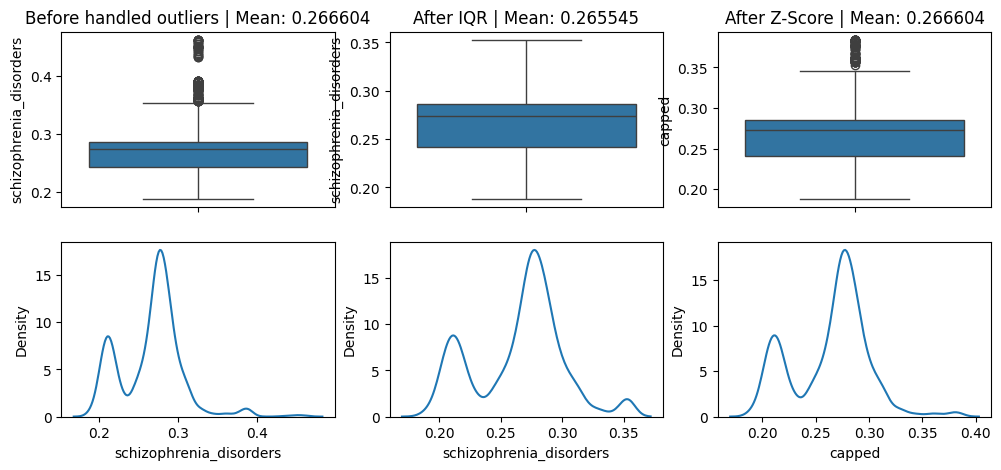

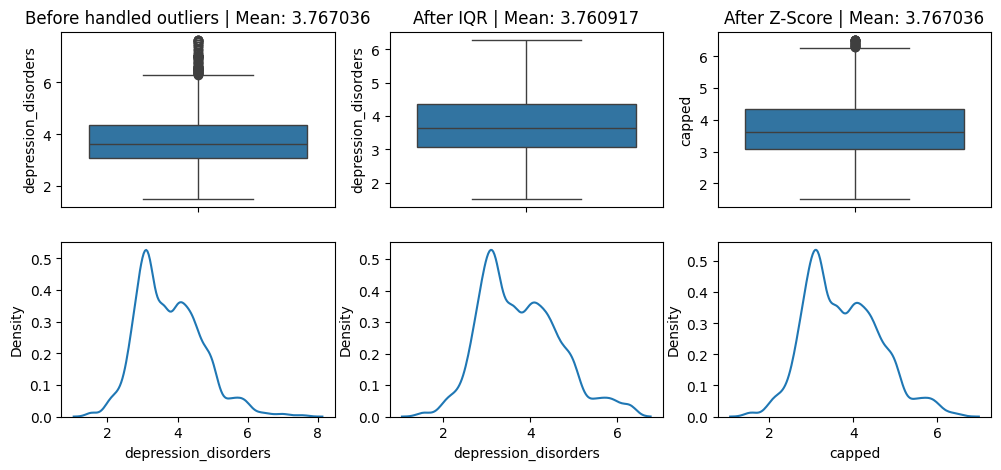

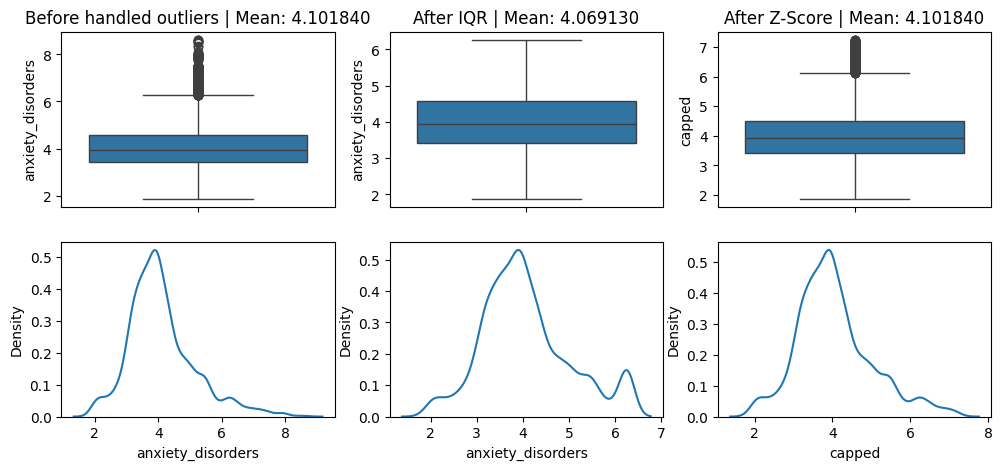

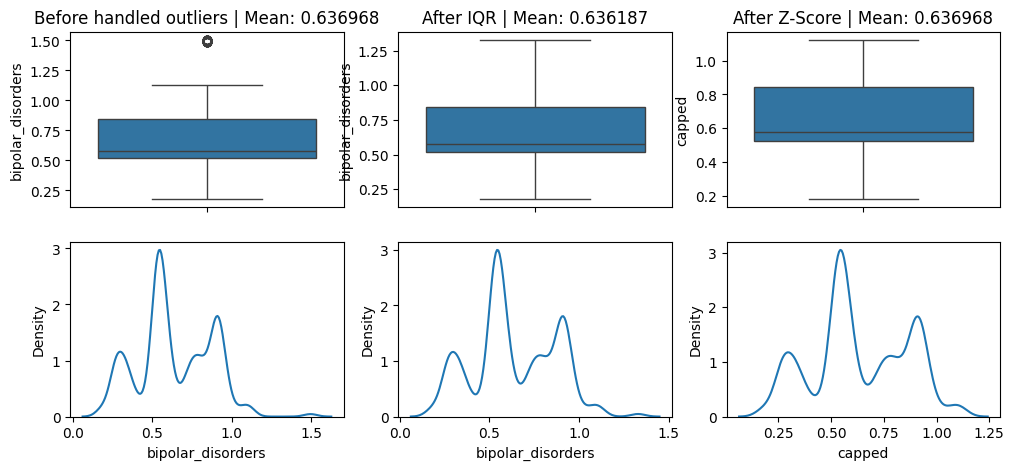

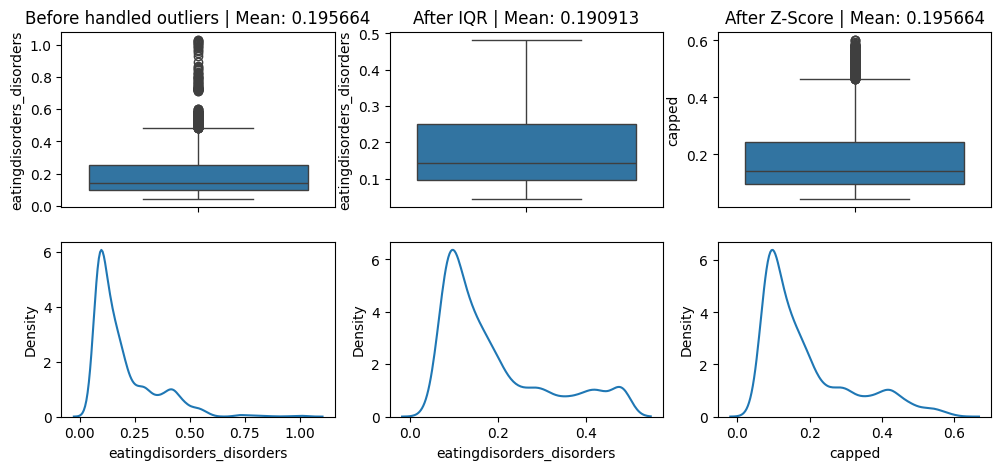

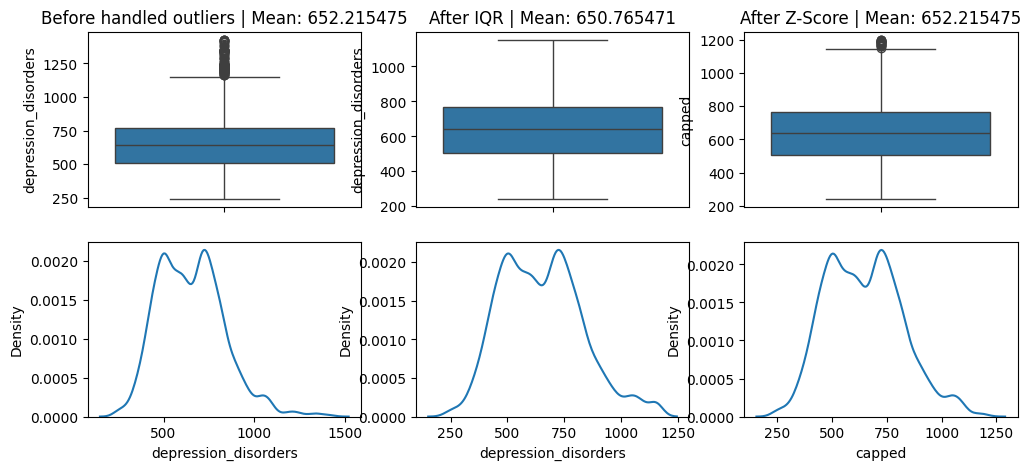

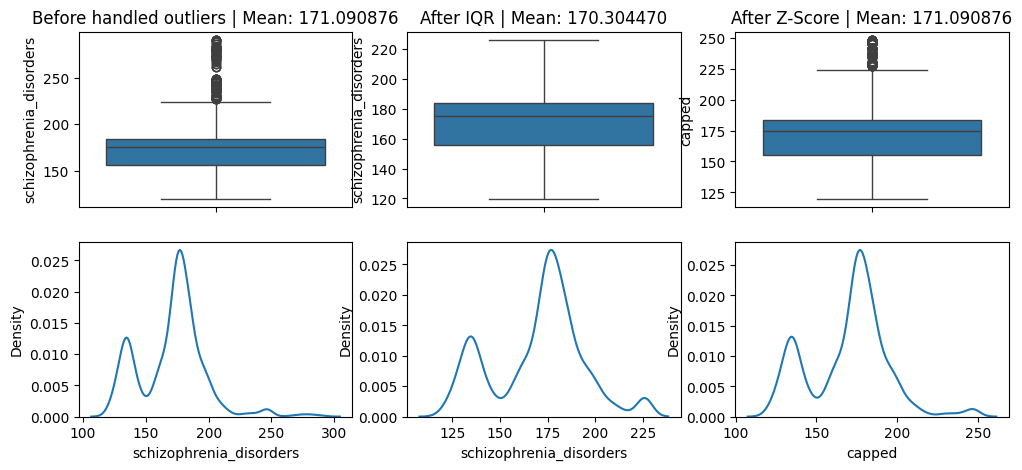

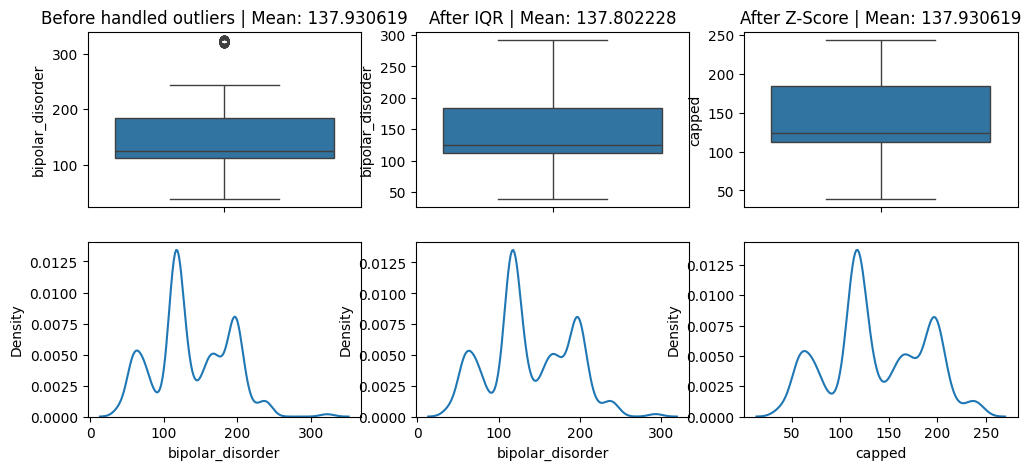

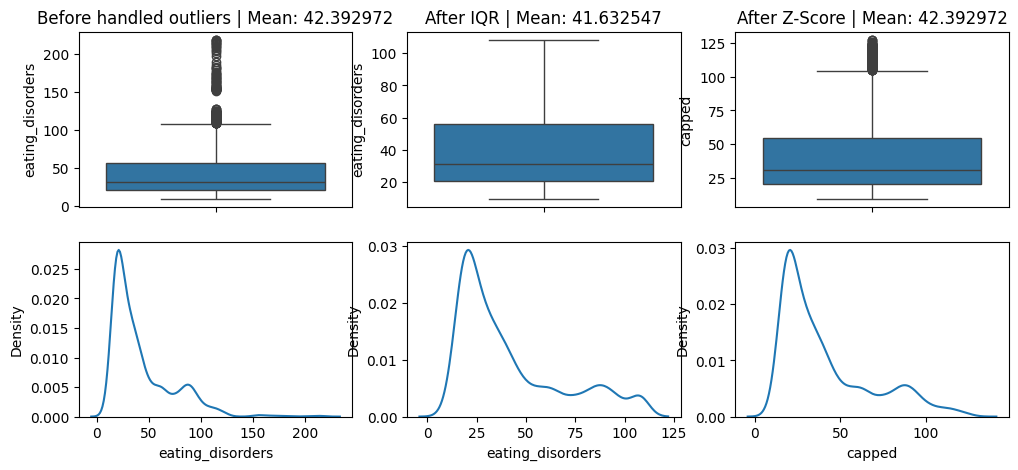

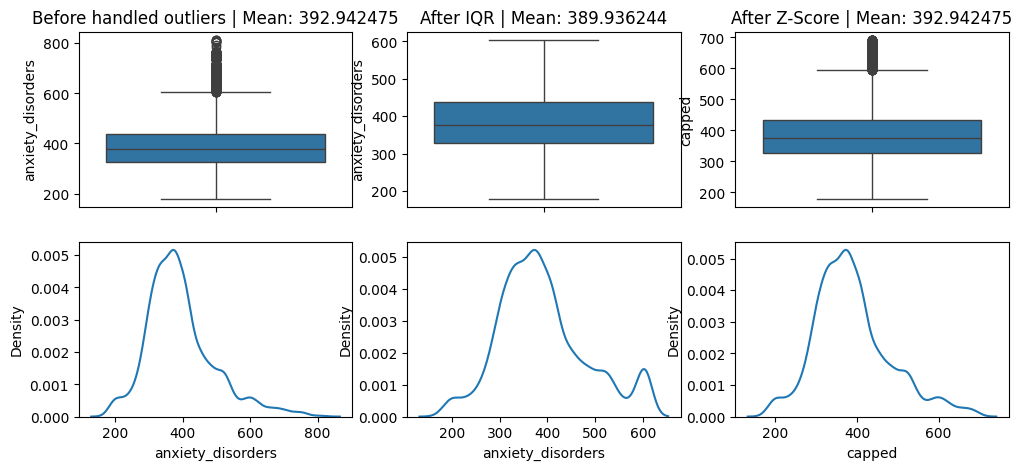

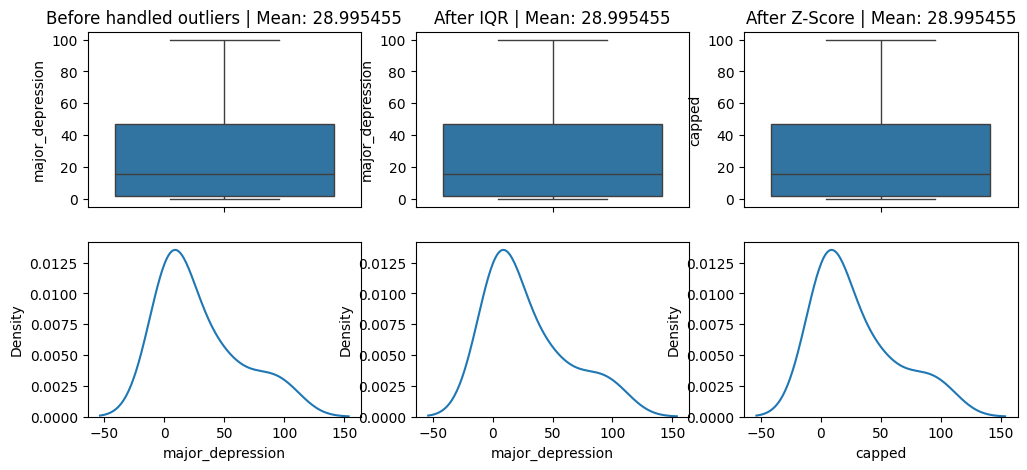

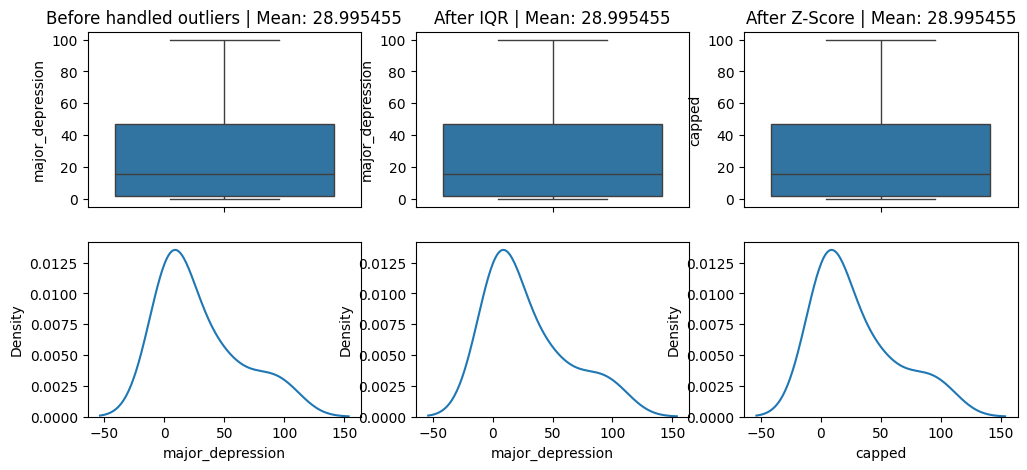

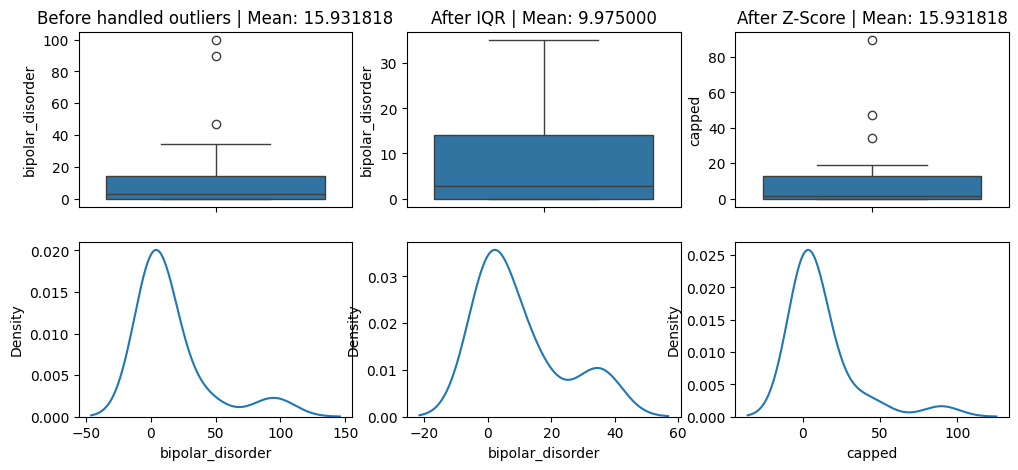

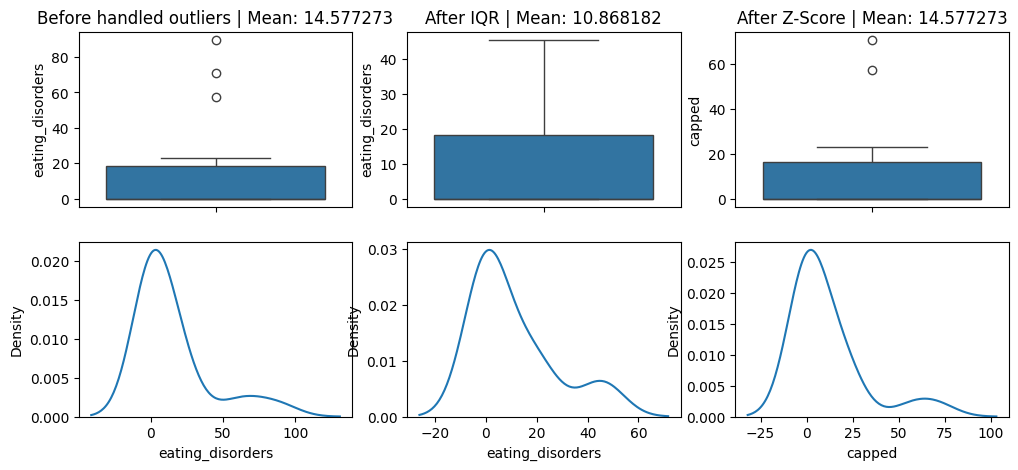

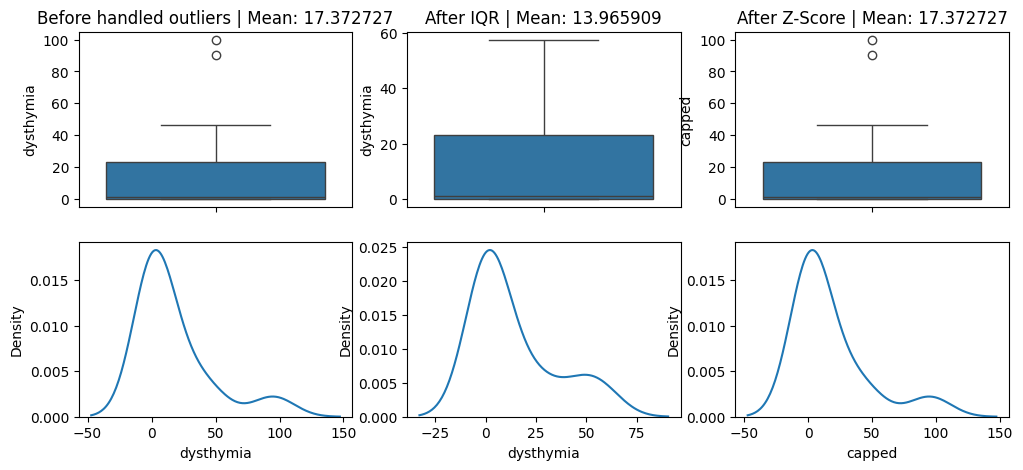

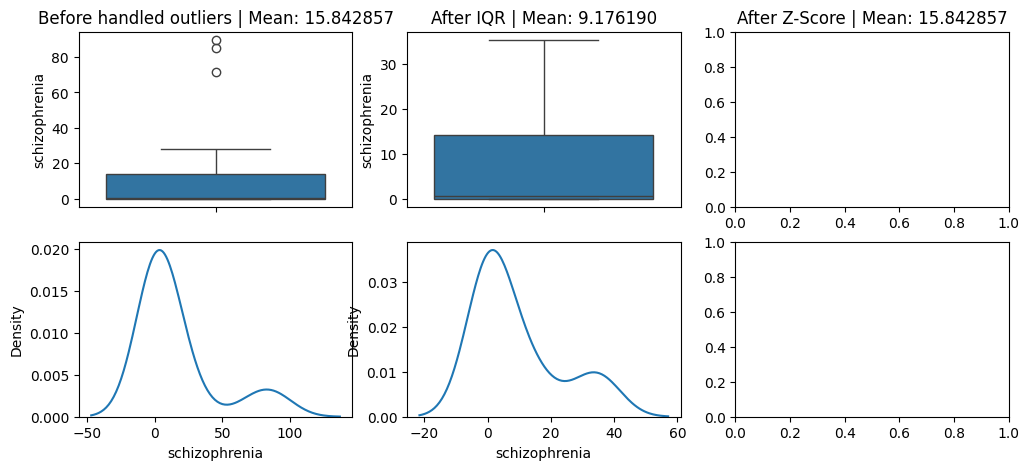

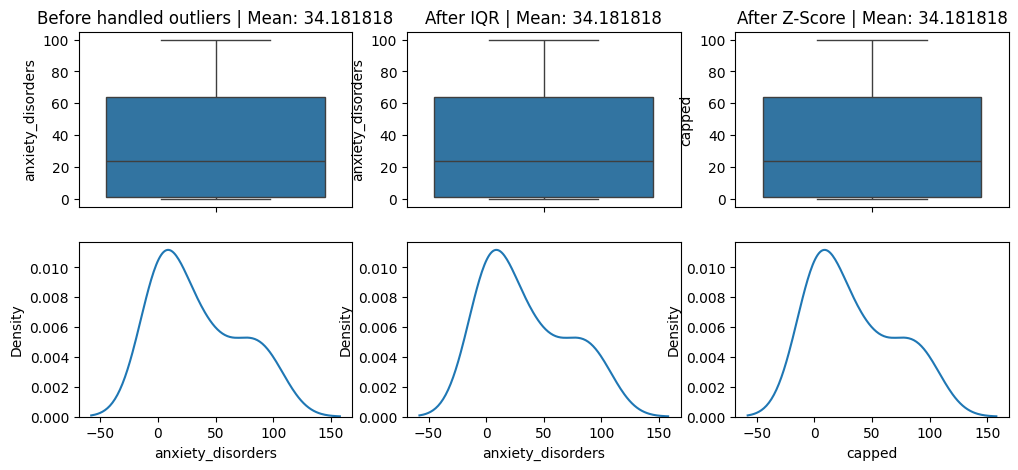

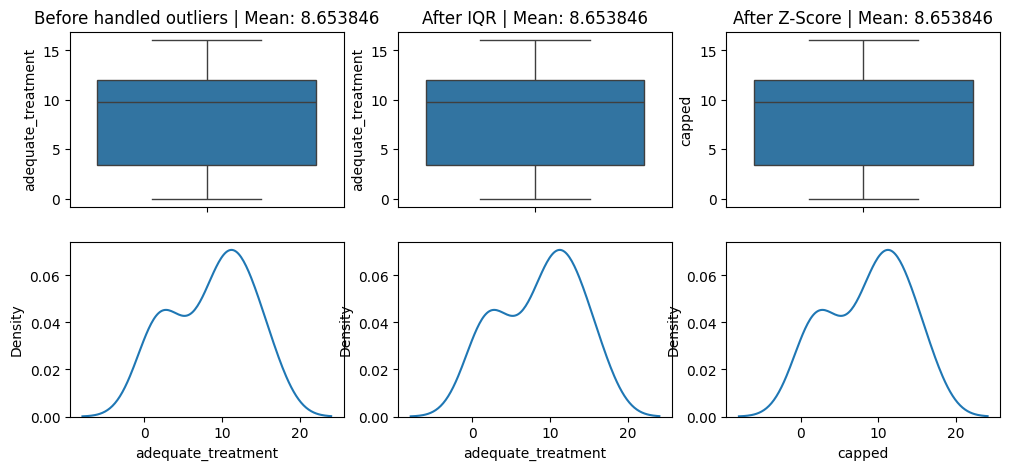

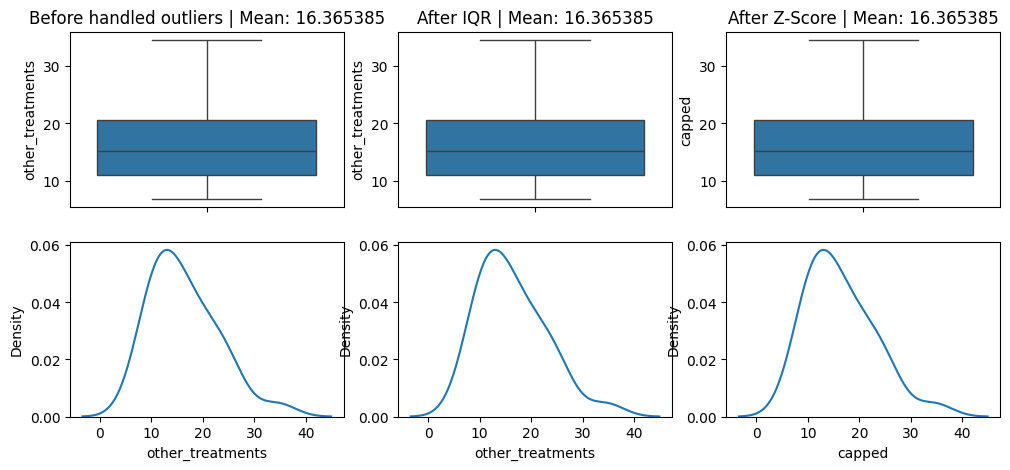

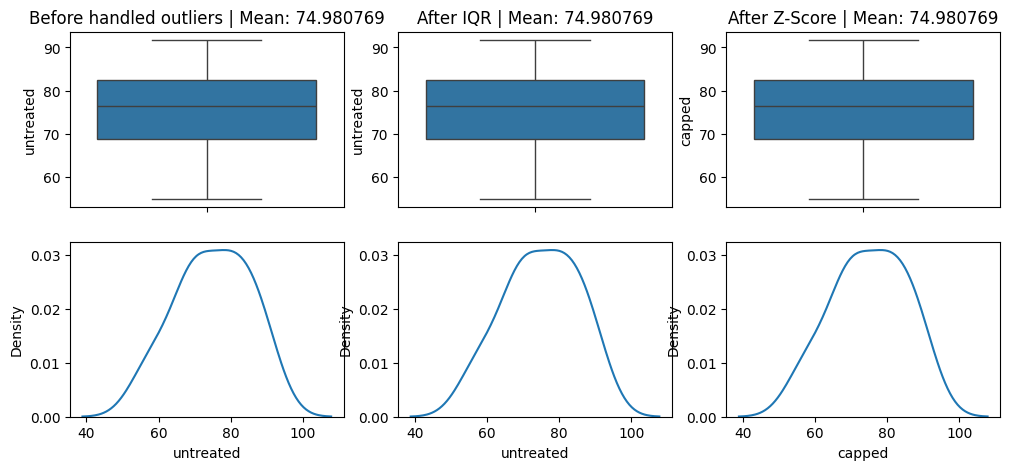

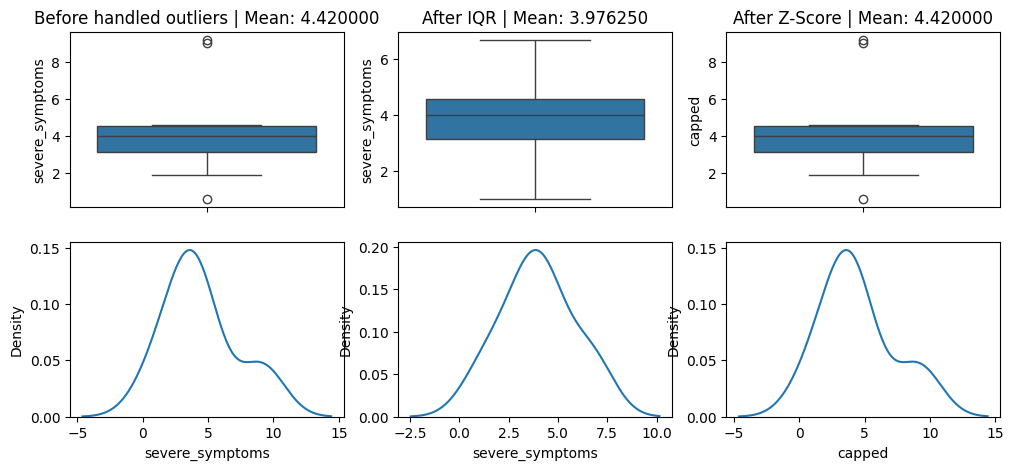

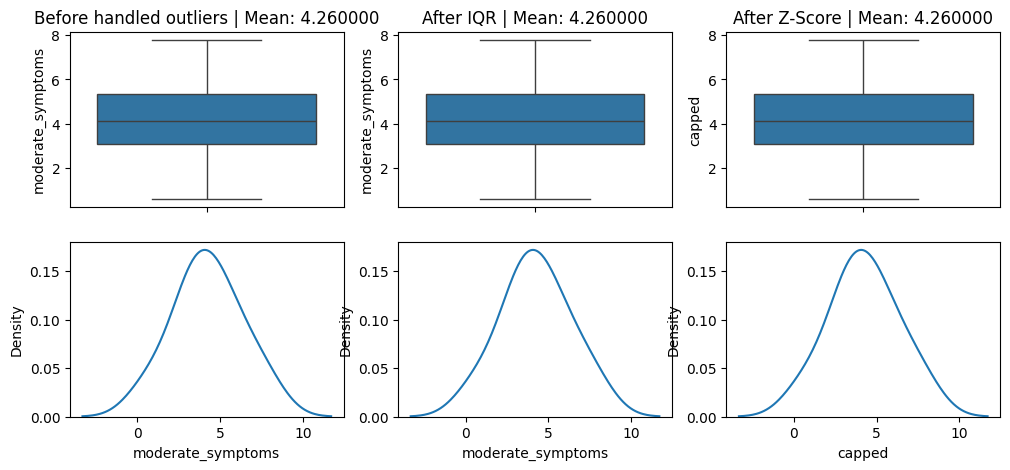

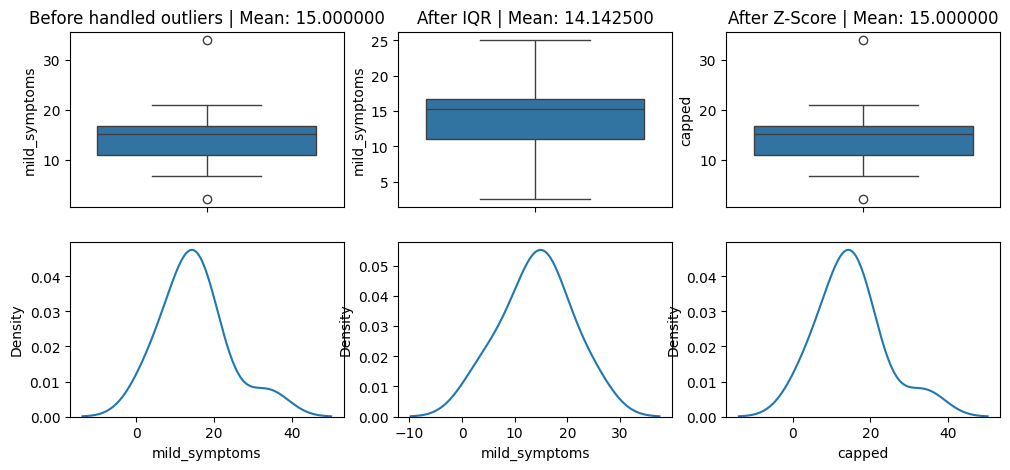

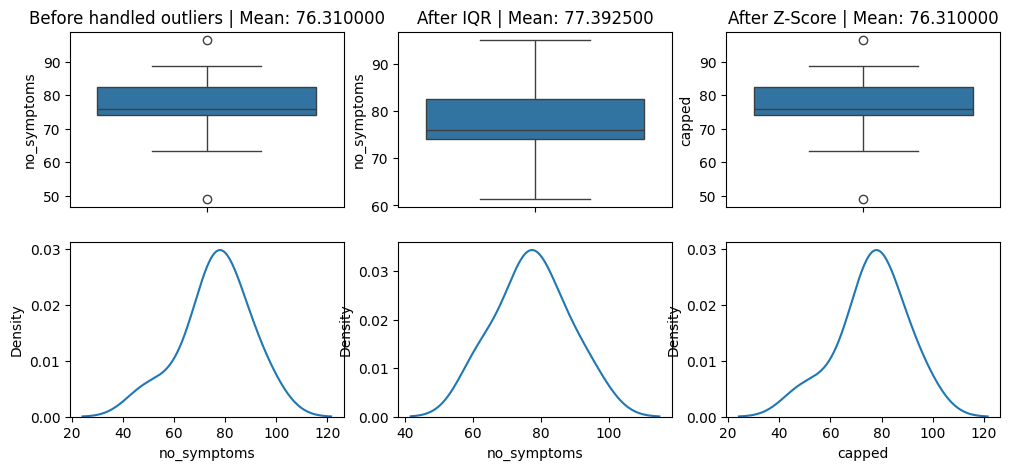

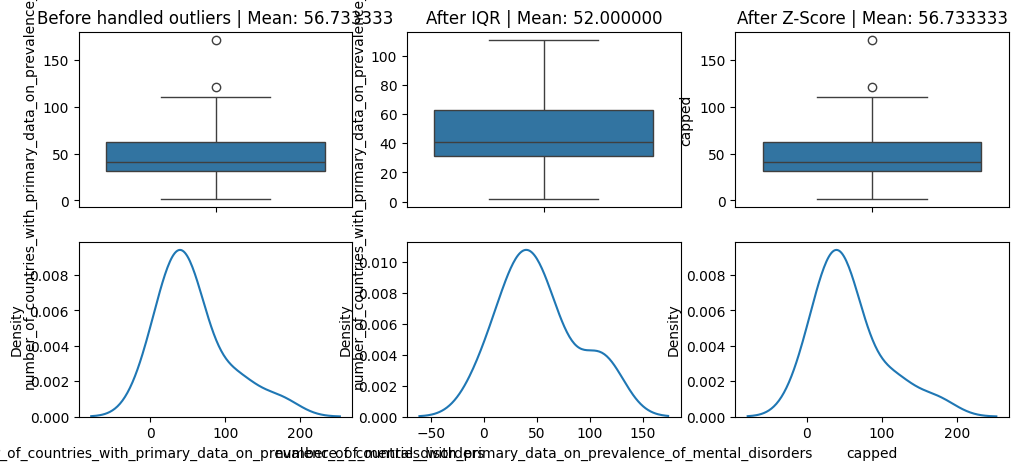

In [26]:
for df in dfs:
    df_skip = df.iloc[:, 2:]
    df_skip = df_skip.apply(pd.to_numeric, errors='coerce') #while developing, detect some values are string type, so using this to safely convert them into numeric

    for column in df_skip:

        #draw boxplot and kde before analyte to visualize the outliers
        fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 5))

        axes[0][0].set_title(f'Before handled outliers | Mean: {df_skip[column].mean():.6f}')
        sns.boxplot(y=df_skip[column], ax=axes[0][0])
        sns.kdeplot(df_skip[column], ax=axes[1][0])

        #handle outliers using IQR
        Q1 = df_skip[column].quantile(0.25)
        Q3 = df_skip[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_iqr = df_skip[[column]].copy()
        df_iqr[column]= df_skip[column].clip(lower=lower_bound, upper=upper_bound)

        #draw boxplot after handling outliers
        axes[0][1].set_title(f'After IQR | Mean: {df_iqr[column].mean():.6f}')
        sns.boxplot(y=df_iqr[column], ax=axes[0][1])
        sns.kdeplot(df_iqr[column], ax=axes[1][1])

        # Try z-score method to compare results with IQR method
        df_z = df_skip[[column]].copy()
        df_z['z_score'] = zscore(df_z[column])
        df_z['capped'] = df_z[column].where(df_z['z_score'].abs() <= 3) #created capped column to cap values smaller or equal to z-score 3 which is 99.7%

        axes[0][2].set_title(f'After Z-Score | Mean: {df_z[column].mean():.6f}')
        sns.boxplot(y=df_z['capped'].dropna(), ax=axes[0][2])
        sns.kdeplot(df_z['capped'].dropna(), ax=axes[1][2])

        plt.show()

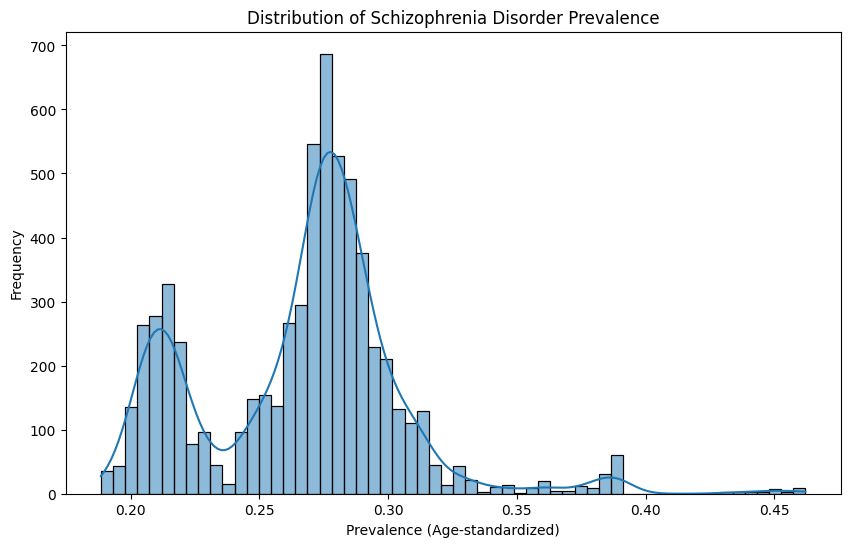

In [27]:
# Example histogram for a targeted variable
# Below this cell will be histograms for all
plt.figure(figsize=(10, 6))
sns.histplot(dfs[0]['schizophrenia_disorders'], kde=True)
plt.title('Distribution of Schizophrenia Disorder Prevalence')
plt.xlabel('Prevalence (Age-standardized)')
plt.ylabel('Frequency')
plt.show()


Plotting histograms for DataFrame 0


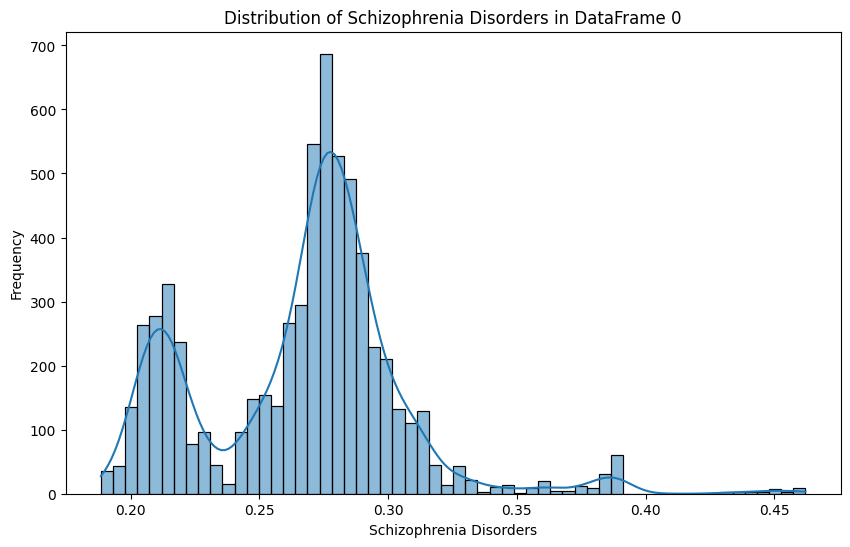

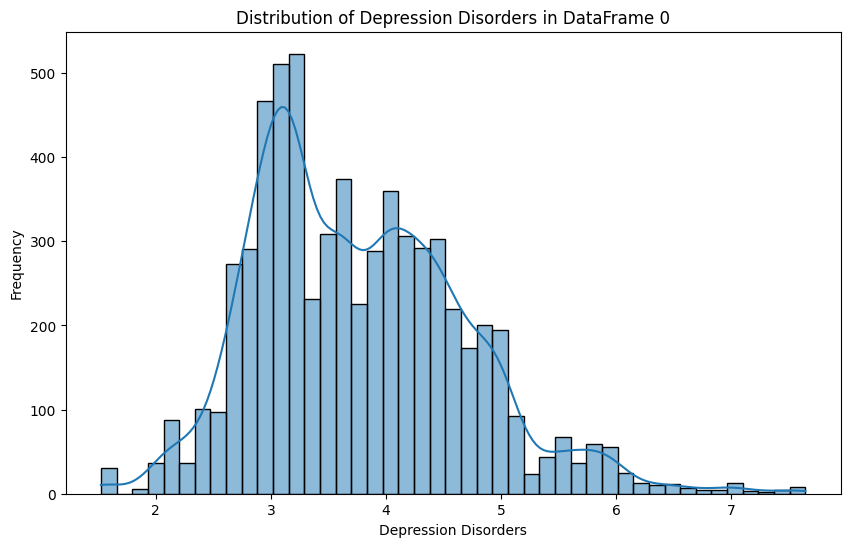

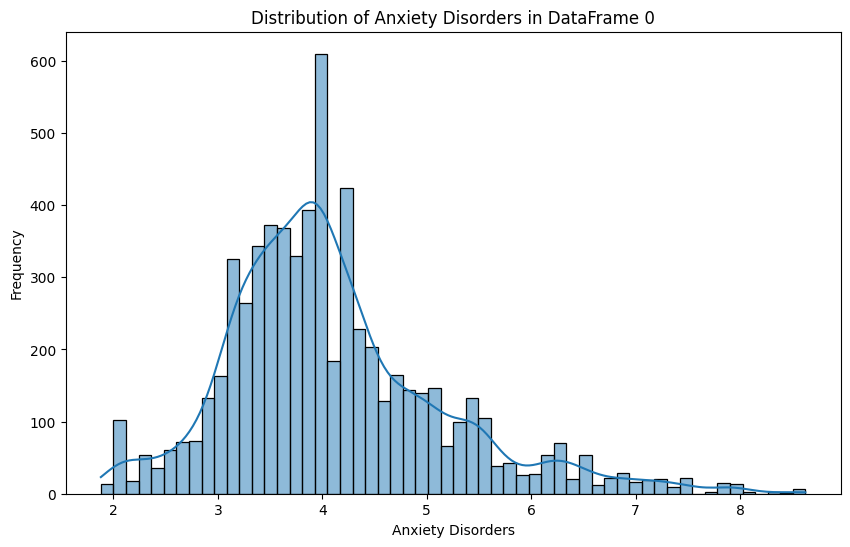

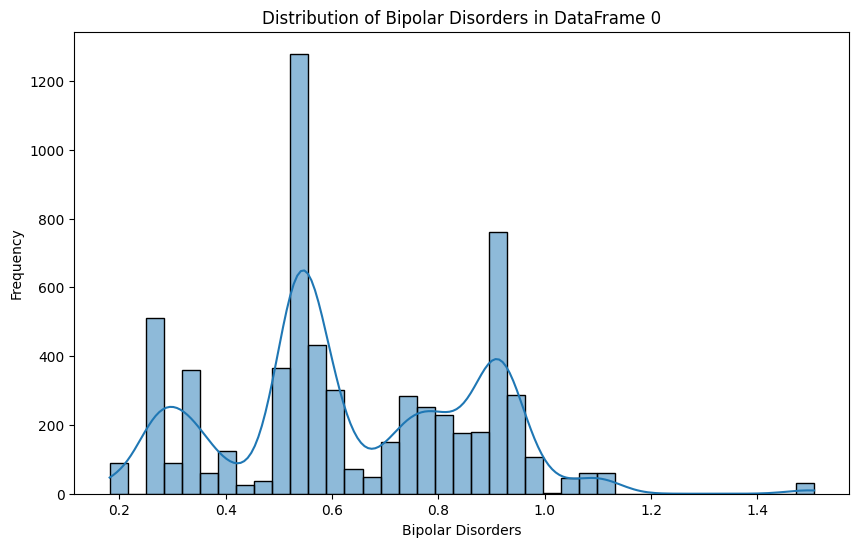

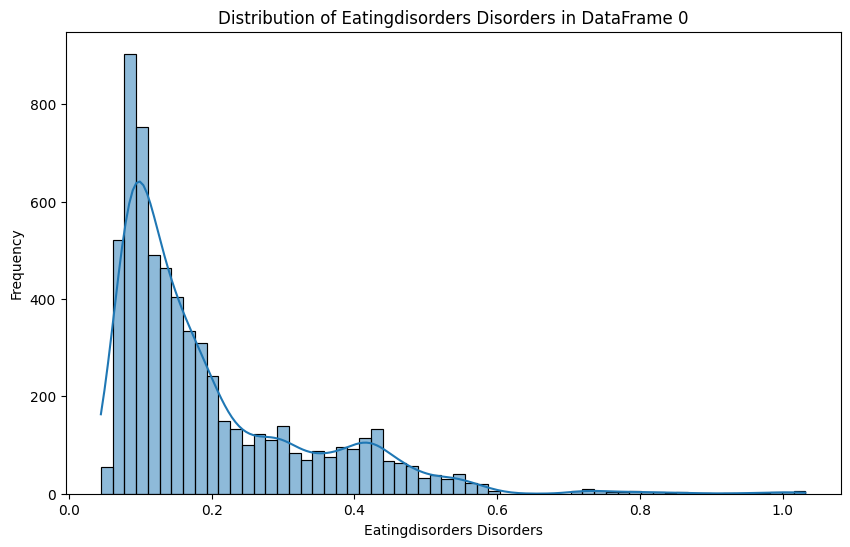


Plotting histograms for DataFrame 1


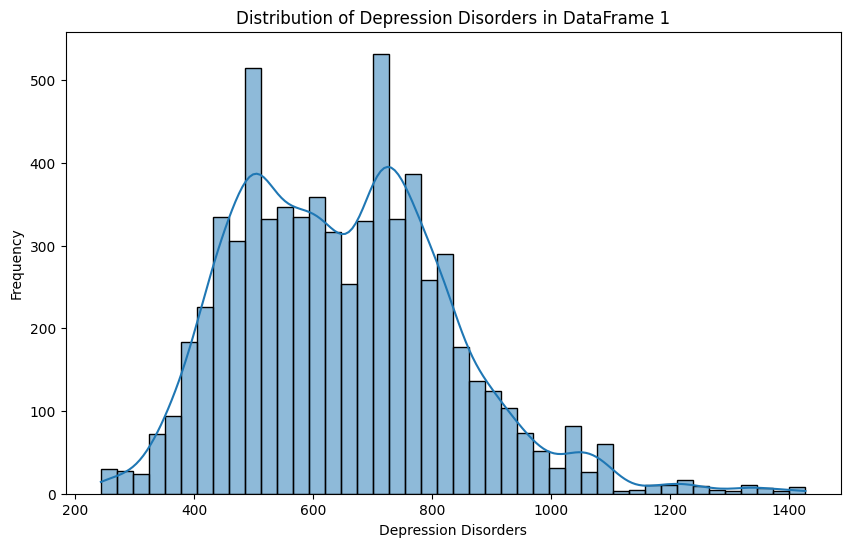

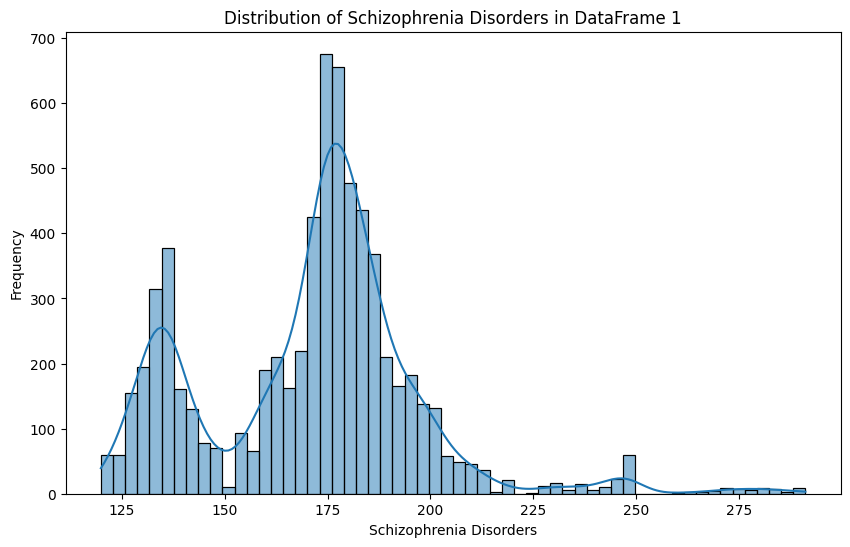

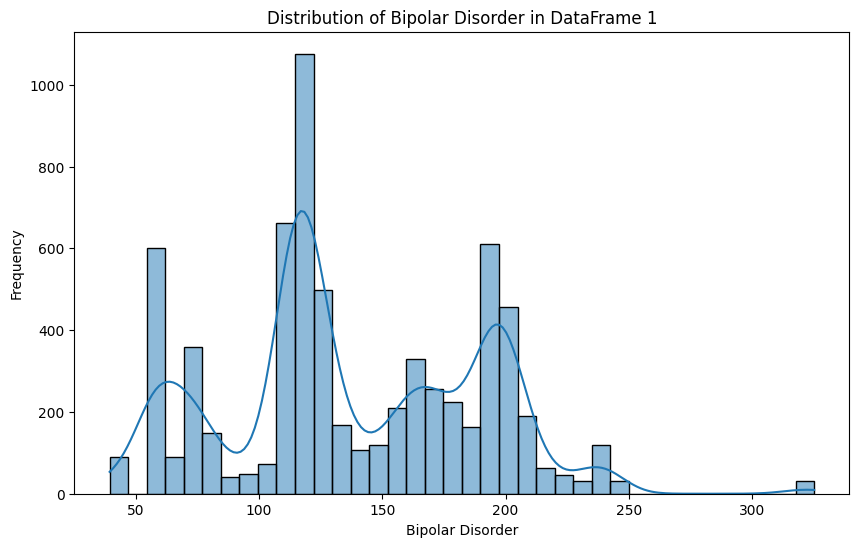

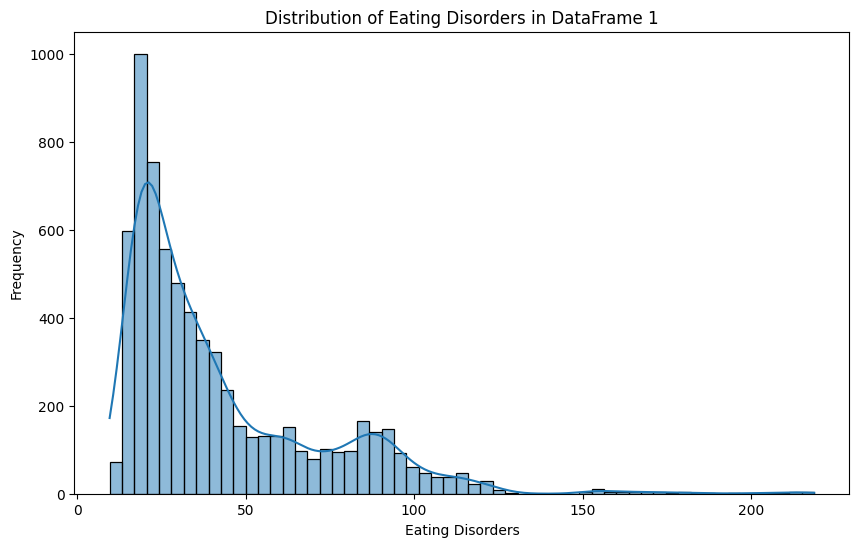

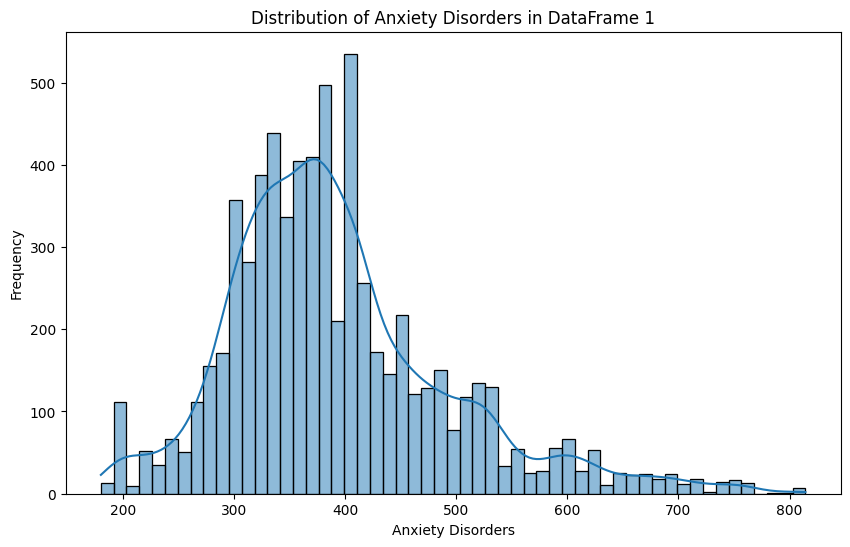


Plotting histograms for DataFrame 2


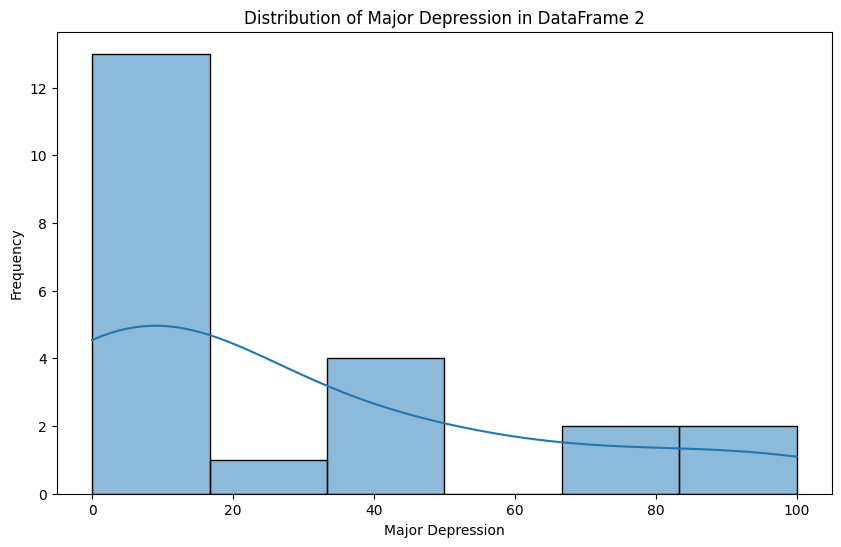


Plotting histograms for DataFrame 3


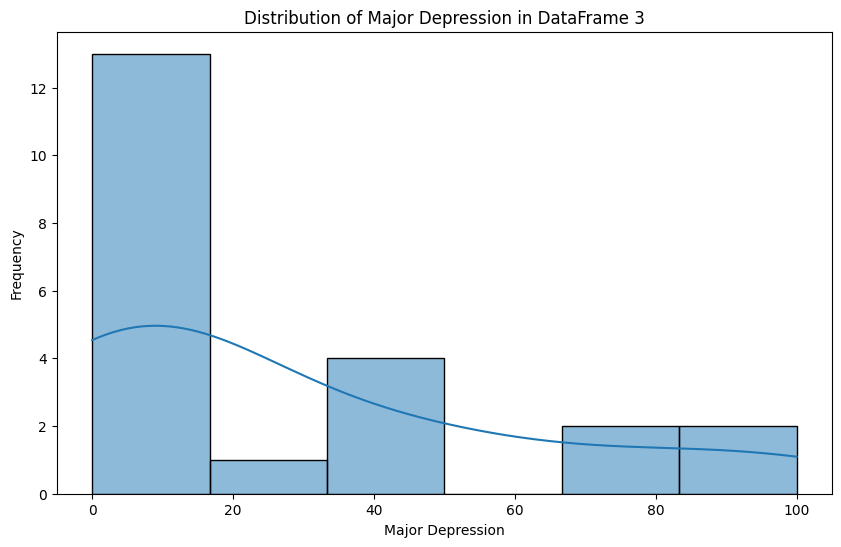

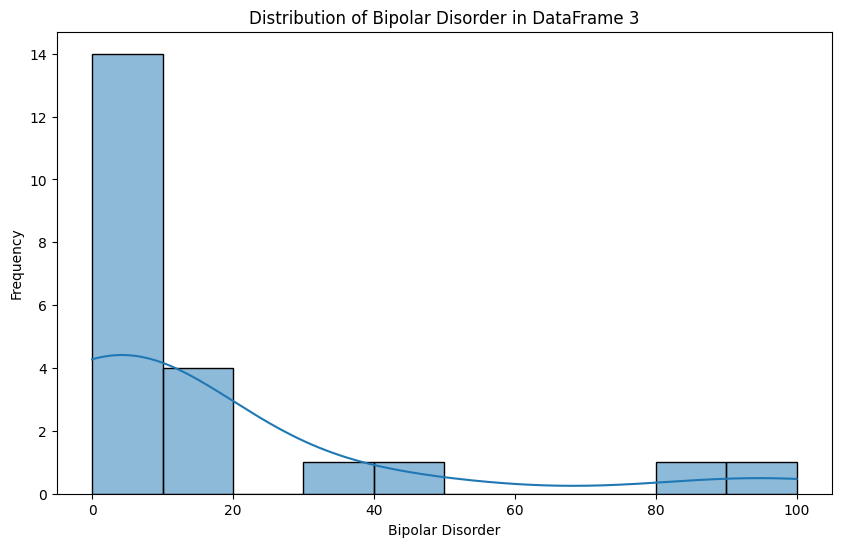

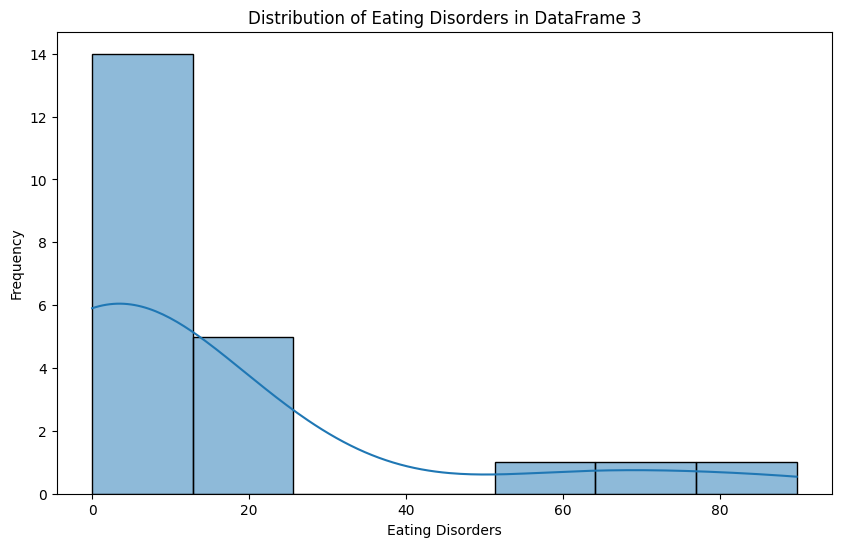

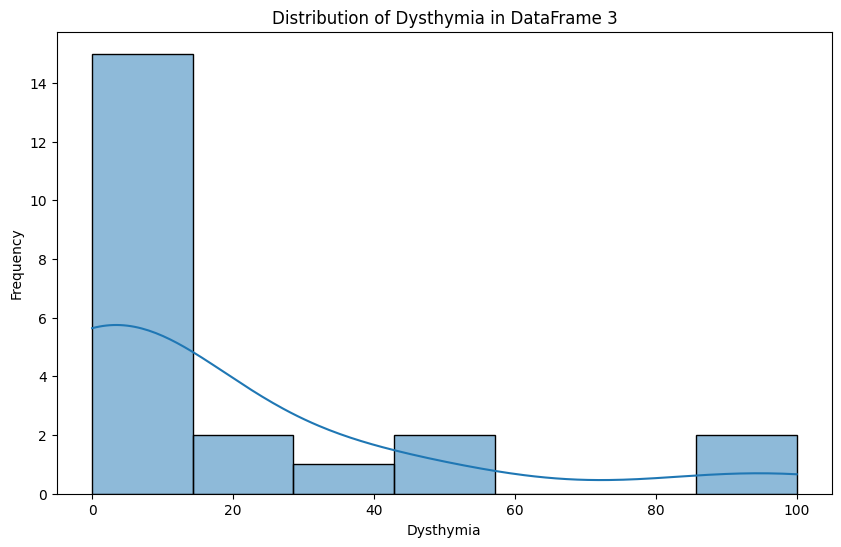

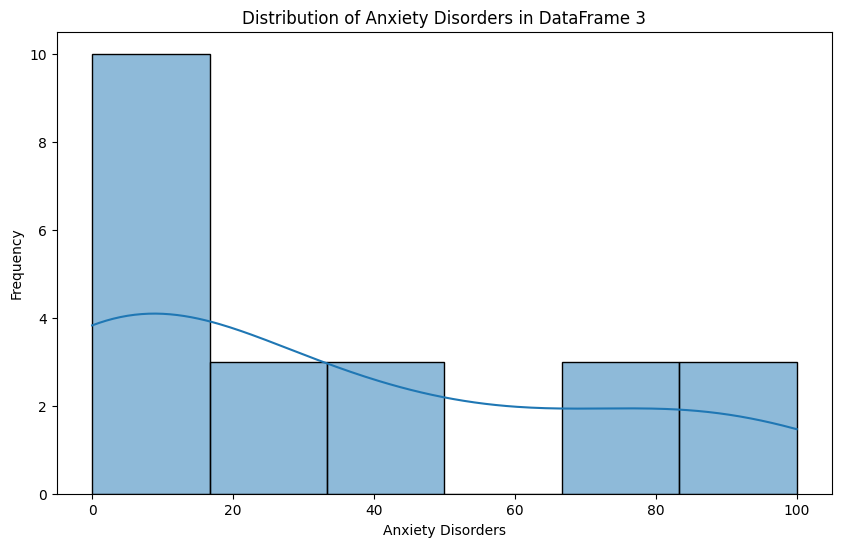


Plotting histograms for DataFrame 4


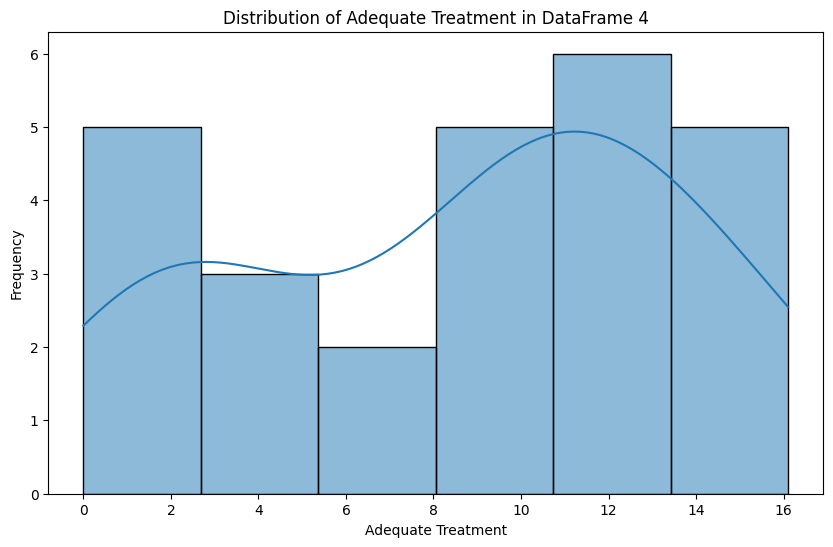

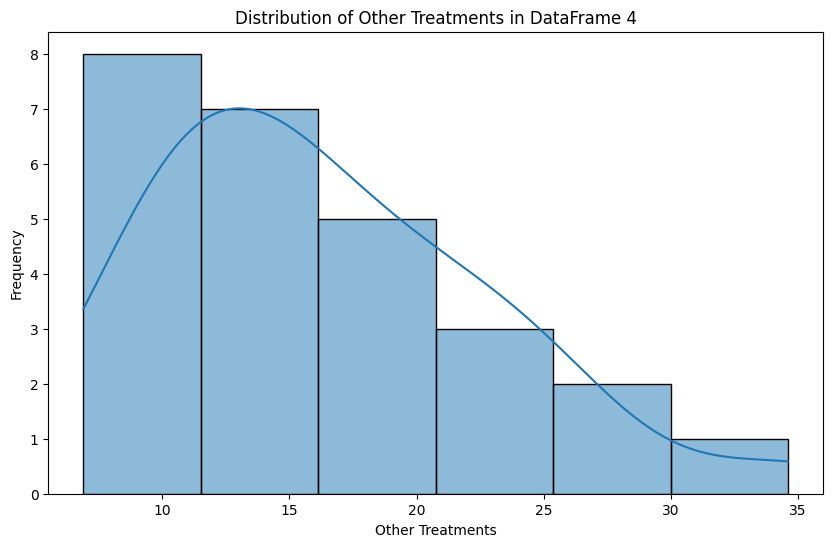

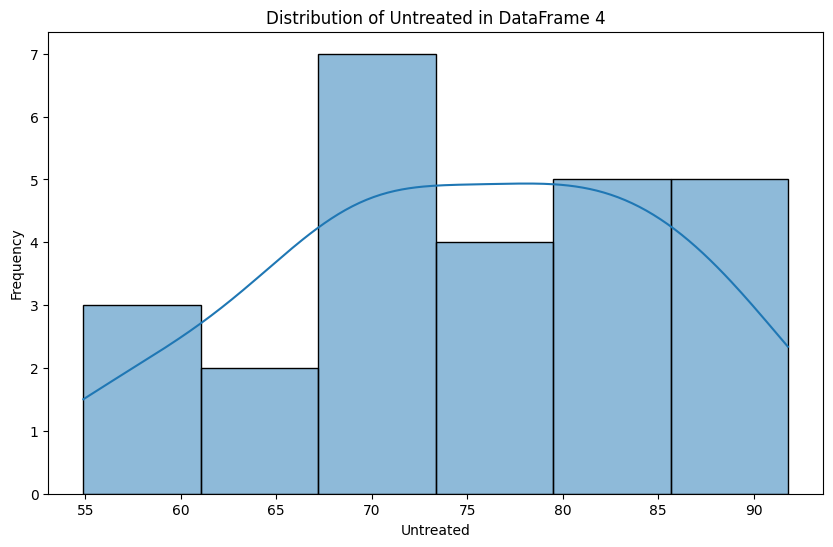


Plotting histograms for DataFrame 5


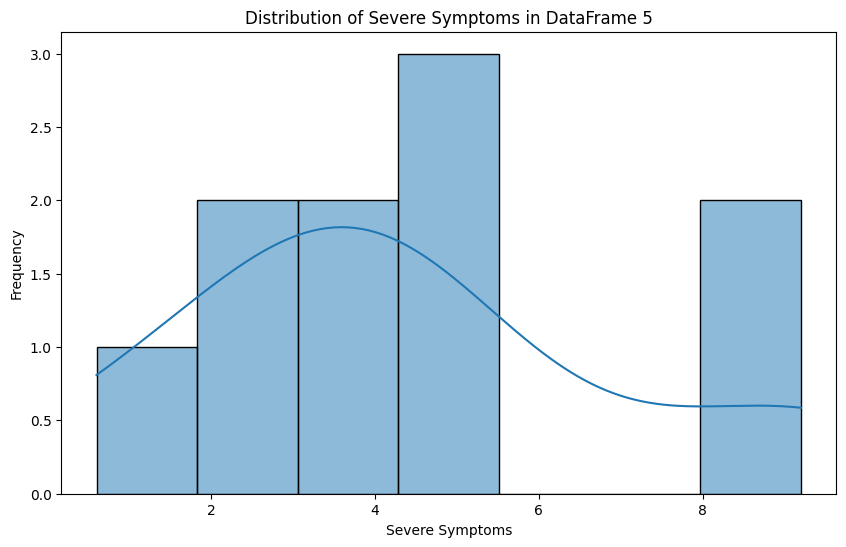

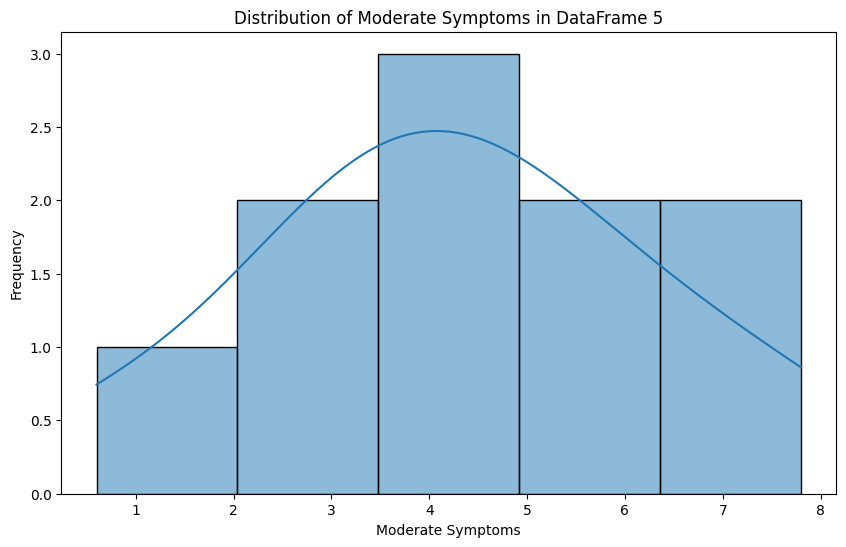

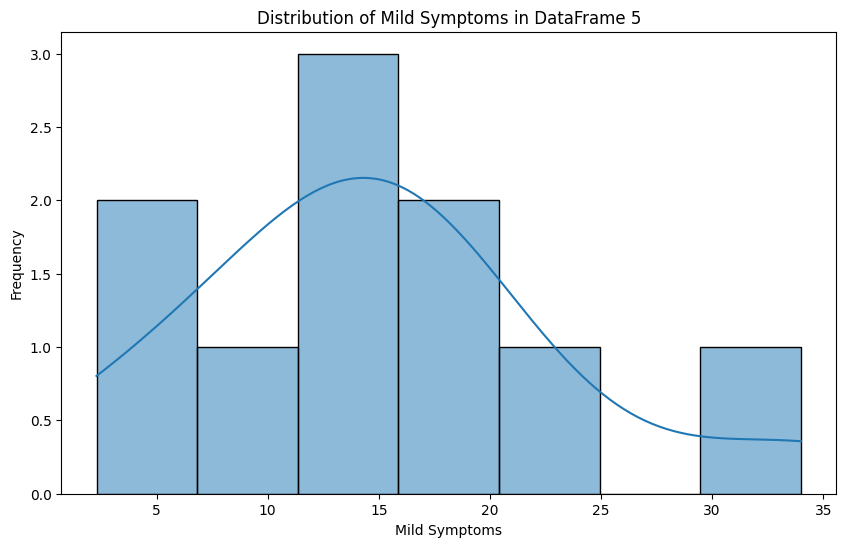

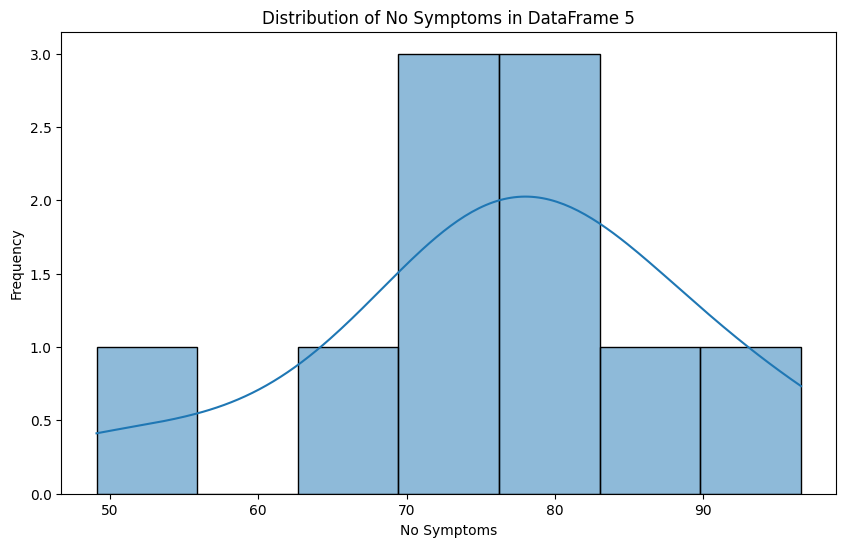


Plotting histograms for DataFrame 6


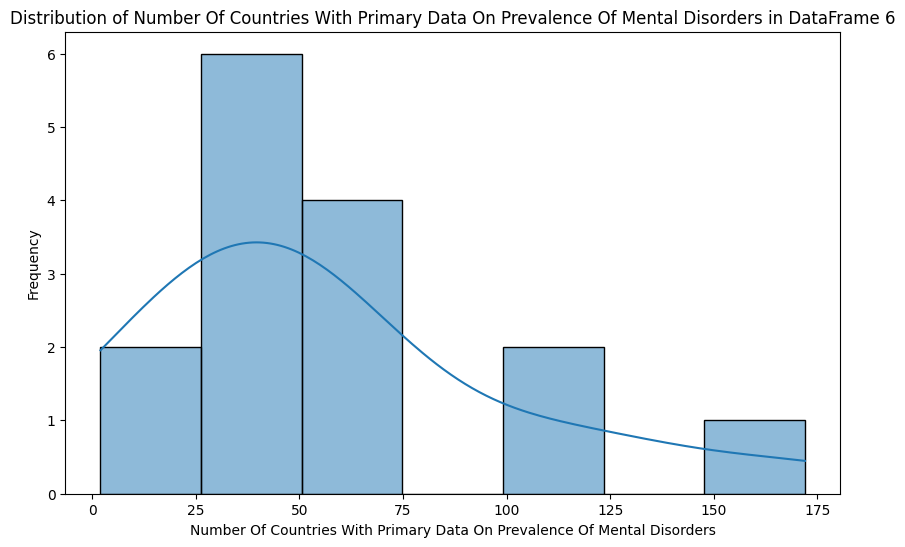

In [28]:
# prompt: great now can you avoid histogram plots where year is the column?

import matplotlib.pyplot as plt
# Function to generate histograms for all numeric columns except 'year'
def plot_histograms(dfs):
  """
    Generates and displays histograms for all numeric columns in each DataFrame
    in the list, skipping the 'year' column if it exists.

    Parameters:
    -----------
    dfs : list of pandas.DataFrame
        A list of DataFrames to plot histograms from.
  """
  for i, df in enumerate(dfs):
    print(f"\nPlotting histograms for DataFrame {i}")
    for col in df.select_dtypes(include='number').columns:
      if col != 'year':  # Skip the 'year' column
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col].dropna(), kde=True) # Drop NA values for plotting
        plt.title(f'Distribution of {col.replace("_", " ").title()} in DataFrame {i}')
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel('Frequency')
        plt.show()

# Call the function to plot histograms for all numeric columns except 'year'
plot_histograms(dfs)


In [29]:
columns_for_correlation = ['schizophrenia_disorders',
                                 'depression_disorders',
                                 'anxiety_disorders',
                                 'bipolar_disorders',
                                 'eatingdisorders_disorders']

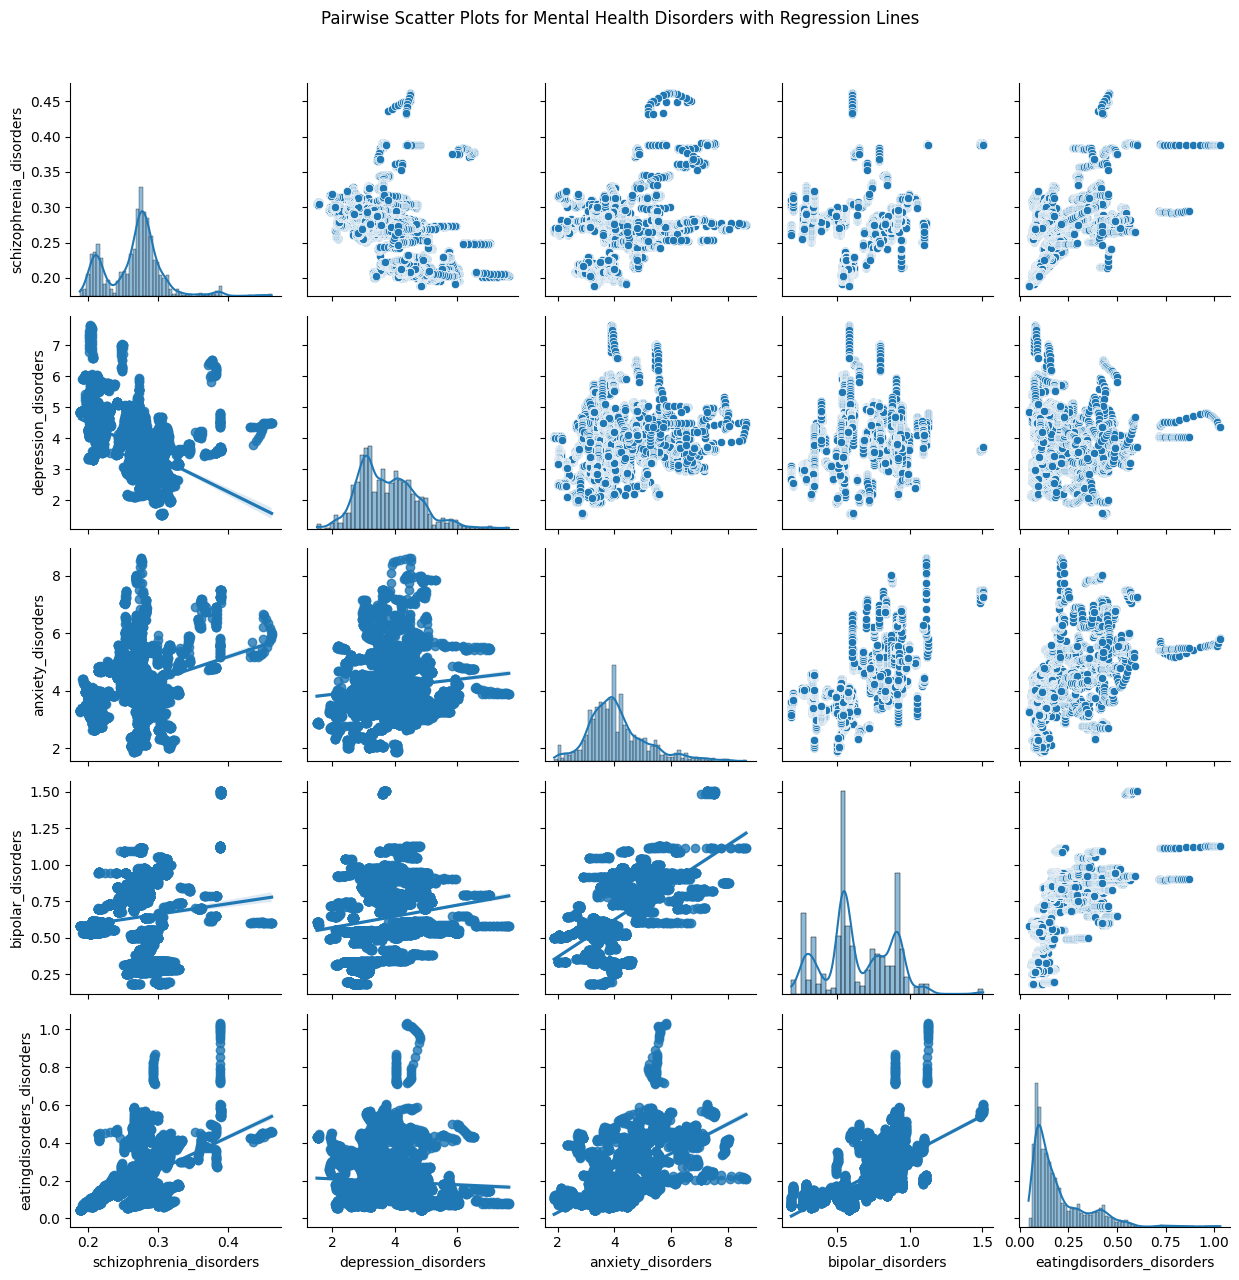

In [30]:
pair_grid = sns.PairGrid(dfs[0], vars=columns_for_correlation)
pair_grid.map_upper(sns.scatterplot)
pair_grid.map_lower(sns.regplot)
pair_grid.map_diag(sns.histplot, kde=True)
plt.suptitle('Pairwise Scatter Plots for Mental Health Disorders with Regression Lines', y=1.02)
plt.tight_layout()
plt.show()